## Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import numpy as np
from numpy import polyfit
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
import tensorflow as tf
import plotly.express as px
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Import And Preprocess Data Set

In [ ]:
df = pd.read_csv("/content/drive/My Drive/CE397Proj/CO2/FinalCo2.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# Convert Effective date type to datetime
df["Date"] = pd.to_datetime(df["Date"])
# df['DATE'] = pd.to_datetime(df['DATE']).dt.tz_localize(None)
df.head(2)

,Date,Value
0,1959-03-01,316.65
1,1959-04-01,317.72


In [ ]:
df.tail()

,Date,Value
777,2023-12-01,421.86
778,2024-01-01,422.80
779,2024-02-01,424.62
780,2024-03-01,425.38
781,2024-04-01,426.57


In [ ]:
df=df.loc[df['Date']>='2000-01-01']

In [ ]:
df.set_index('Date', inplace=True)

df.head()

,Value
Date,
2000-01-01,369.45
2000-02-01,369.71
2000-03-01,370.75
2000-04-01,371.98
2000-05-01,371.74


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 292 entries, 2000-01-01 to 2024-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   292 non-null    float64
dtypes: float64(1)
memory usage: 4.6 KB


In [ ]:
train = df[:190]
valid = df[190:250]
test = df[250:]

scaler = MinMaxScaler()

# Fit scaler on training data and transform all subsets
train_data = scaler.fit_transform(train[['Value']])
validate_data = scaler.transform(valid[['Value']])
test_data = scaler.transform(test[['Value']])

print("Train data size:", len(train_data))
print("Validation data size:", len(validate_data))
print("Test data size:", len(test_data))


Train data size: 190
Validation data size: 60
Test data size: 42


In [ ]:
from keras.layers import Bidirectional
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10 # Number of time steps to look back
X_train, y_train = create_sequences(train_data, seq_length)
X_val,y_val=create_sequences(validate_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

### Implemented Code

In [ ]:
def create_train_lstm_model_grid_search(activation_function, optimizer_name):
    """
    Creates, compiles, and trains a CNN model with the specified activation function and optimizer.

    Args:
        activation_function: The activation function to use in the model layers.
        optimizer_name: The name of the optimizer to use ('adam', 'adamw', or 'adamax').

    Returns:
        A tuple containing the trained Keras model and its training history.
    """
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation=activation_function, input_shape=(seq_length, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation=activation_function))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation=activation_function))
    model.add(Dense(1)) # Linear activation for regression

    if optimizer_name == 'adam':
        optimizer = optimizers.Adam()
    elif optimizer_name == 'adamw':
        optimizer = optimizers.AdamW()
    elif optimizer_name == 'adamax':
        optimizer = optimizers.Adamax()
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}. Choose from 'adam', 'adamw', or 'adamax'.")


    model.compile(optimizer=optimizer, loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=0, callbacks=[early_stopping])

    return model, history

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from numpy import sqrt

activation_functions = ['sigmoid', 'tanh', 'relu', 'leaky_relu', 'silu', 'gelu']
optimizers_list = ['adam', 'adamw', 'adamax']
num_trials = 5 # Number of trials for each combination
grid_search_results = {}

for activation in activation_functions:
    grid_search_results[activation] = {}
    for optimizer_name in optimizers_list:
        grid_search_results[activation][optimizer_name] = []

for trial in range(num_trials):
    print(f"--- Starting Grid Search Trial {trial + 1}/{num_trials} ---")
    for activation in activation_functions:
        for optimizer_name in optimizers_list:
            print(f"Training model with {activation} activation and {optimizer_name} optimizer for Trial {trial + 1}...")
            model, history = create_train_lstm_model_grid_search(activation, optimizer_name)

            # Evaluate the model
            test_predict = model.predict(X_test)
            test_predict = scaler.inverse_transform(test_predict)
            y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

            test_mse = mean_squared_error(y_test_inv, test_predict)
            test_rmse = sqrt(test_mse)
            test_mae = mean_absolute_error(y_test_inv, test_predict)

            # Calculate average test error for this trial and combination
            average_error = (test_mse + test_rmse + test_mae) / 3

            # Store the result
            grid_search_results[activation][optimizer_name].append(average_error)

            print(f"Finished training and evaluating model with {activation} activation and {optimizer_name} optimizer for Trial {trial + 1}.")

print("\n--- Grid Search completed ---")

--- Starting Grid Search Trial 1/5 ---
Training model with sigmoid activation and adam optimizer for Trial 1...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
Finished training and evaluating model with sigmoid activation and adam optimizer for Trial 1.
Training model with sigmoid activation and adamw optimizer for Trial 1...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
Finished training and evaluating model with sigmoid activation and adamw optimizer for Trial 1.
Training model with sigmoid activation and adamax optimizer for Trial 1...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
Finished training and evaluating model with sigmoid activation and adamax optimizer for Trial 1.
Training model with tanh activation and adam optimizer for Trial 1...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
Finished training and evaluating model with tanh activation and adam optimizer for Trial 1.
Training model with tanh activation and adamw optimizer for Trial 1...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
Finished training and evaluating model with tanh activation and adamw optimizer for Trial 1.
Training model with tanh activation and adamax optimizer for Trial 1...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
Finished training and evaluating model with tanh activation and adamax optimizer for Trial 1.
Training model with relu activation and adam optimizer for Trial 1...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
Finished training and evaluating model with relu activation and adam optimizer for Trial 1.
Training model with relu activation and adamw optimizer for Trial 1...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
Finished training and evaluating model with relu activation and adamw optimizer for Trial 1.
Training model with relu activation and adamax optimizer for Trial 1...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Finished training and evaluating model with relu activation and adamax optimizer for Trial 1.
Training model with leaky_relu activation and adam optimizer for Trial 1...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Finished training and evaluating model with leaky_relu activation and adam optimizer for Trial 1.
Training model with leaky_relu activation and

In [ ]:
average_grid_search_results = {}
for activation in activation_functions:
    average_grid_search_results[activation] = {}
    for optimizer_name in optimizers_list:
        average_error = sum(grid_search_results[activation][optimizer_name]) / num_trials
        average_grid_search_results[activation][optimizer_name] = average_error

# Find the best combination
best_combination = None
min_average_error = float('inf')

for activation, optimizer_results in average_grid_search_results.items():
    for optimizer_name, average_error in optimizer_results.items():
        if average_error < min_average_error:
            min_average_error = average_error
            best_combination = (activation, optimizer_name)

print("Average error for each combination across all trials:")
for activation, optimizer_results in average_grid_search_results.items():
    for optimizer_name, average_error in optimizer_results.items():
        print(f"  {activation} + {optimizer_name}: {average_error:.4f}")

print(f"\nThe best combination of activation function and optimizer is: {best_combination}")
print(f"With an average error of: {min_average_error:.4f}")

Average error for each combination across all trials:
  sigmoid + adam: 113.2519
  sigmoid + adamw: 78.1944
  sigmoid + adamax: 294.4789
  tanh + adam: 4.0611
  tanh + adamw: 4.4646
  tanh + adamax: 8.8418
  relu + adam: 1.2671
  relu + adamw: 1.7058
  relu + adamax: 1.5540
  leaky_relu + adam: 1.2363
  leaky_relu + adamw: 1.0000
  leaky_relu + adamax: 1.4330
  silu + adam: 1.3859
  silu + adamw: 1.4511
  silu + adamax: 3.4733
  gelu + adam: 1.1887
  gelu + adamw: 1.1824
  gelu + adamax: 4.5286

The best combination of activation function and optimizer is: ('leaky_relu', 'adamw')
With an average error of: 1.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
Best Model Performance Metrics:
  Test MSE: 1.4364
  Test RMSE: 1.1985
  Test MAE: 0.9956
  Test R²: 0.8613
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


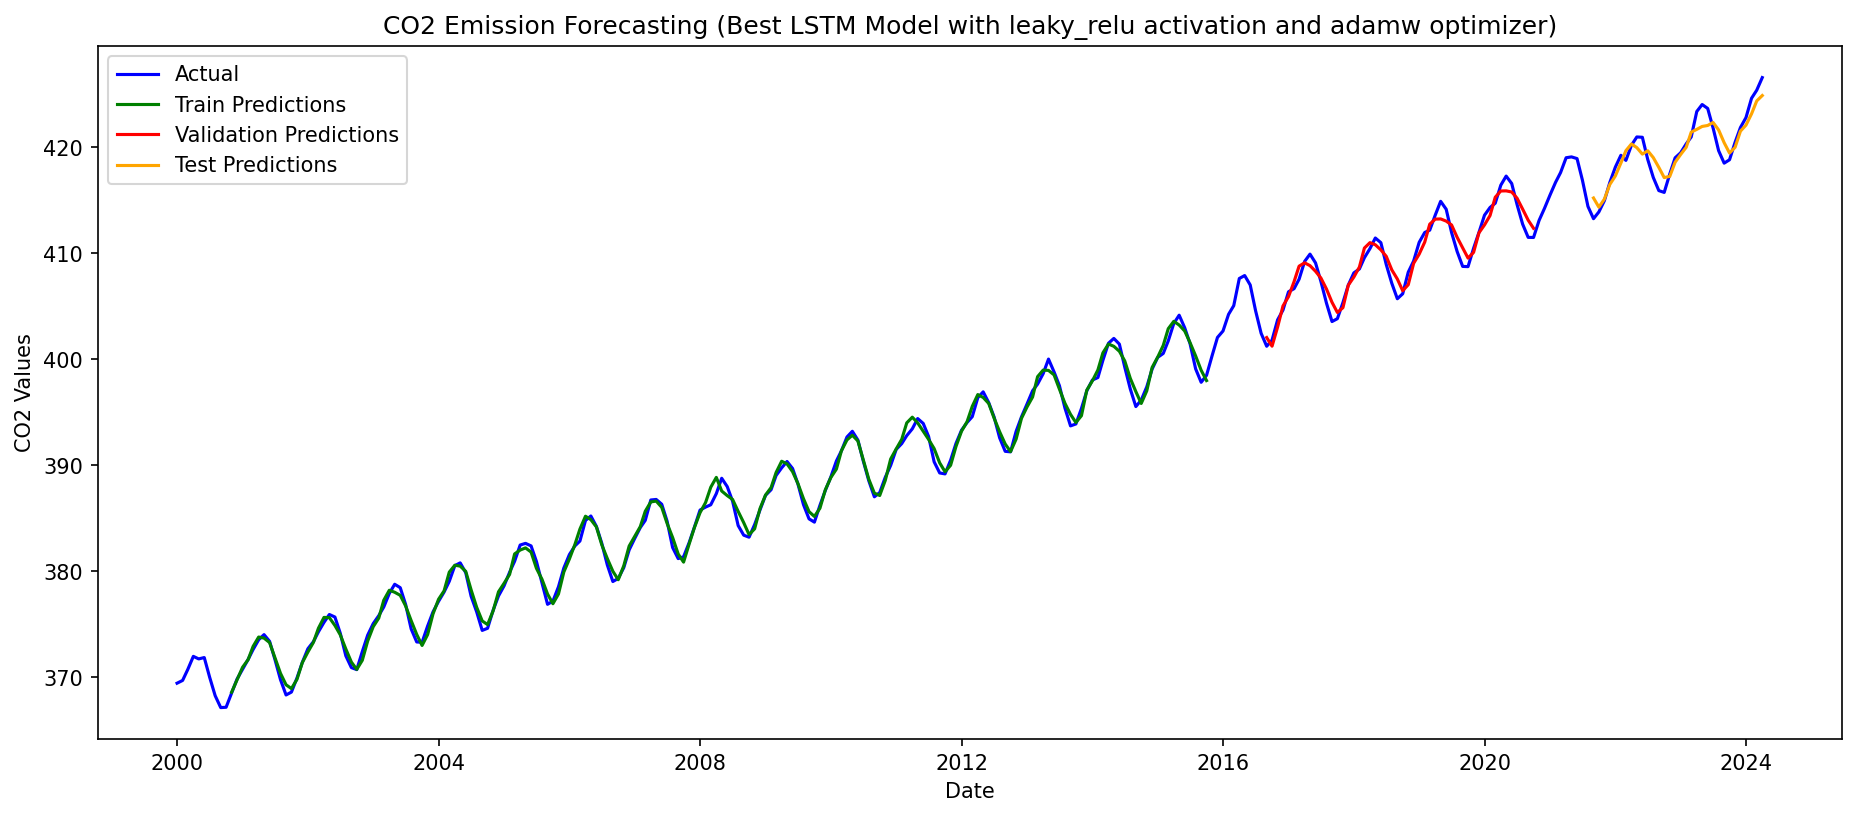

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from numpy import sqrt

# Train the final model using the best combination
best_activation, best_optimizer = best_combination
best_model, best_history = create_train_lstm_model_grid_search(best_activation, best_optimizer)

# Evaluate the best model
test_predict_best = best_model.predict(X_test)

# Inverse transform the predictions and actual values
test_predict_best_inv = scaler.inverse_transform(test_predict_best)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate performance metrics for the best model
best_test_mse = mean_squared_error(y_test_inv, test_predict_best_inv)
best_test_rmse = sqrt(best_test_mse)
best_test_mae = mean_absolute_error(y_test_inv, test_predict_best_inv)
best_test_r2 = r2_score(y_test_inv, test_predict_best_inv)

# Print the metrics for the best model
print("Best Model Performance Metrics:")
print(f"  Test MSE: {best_test_mse:.4f}")
print(f"  Test RMSE: {best_test_rmse:.4f}")
print(f"  Test MAE: {best_test_mae:.4f}")
print(f"  Test R²: {best_test_r2:.4f}")

# Plotting
plt.figure(figsize=(15, 6), dpi=150)

# Plot actual values
plt.plot(df.index, df['Value'], label='Actual', color='blue')

# Generate and plot training predictions for the best model
train_predict_best = best_model.predict(X_train)
train_predict_best_inv = scaler.inverse_transform(train_predict_best)
# Adjust the index for training predictions
plt.plot(df.index[seq_length : len(train) ], train_predict_best_inv.flatten(), label='Train Predictions', color='green')

# Generate and plot validation predictions for the best model
val_predict_best = best_model.predict(X_val)
val_predict_best_inv = scaler.inverse_transform(val_predict_best)
# Adjust the index for validation predictions
plt.plot(df.index[len(train) + seq_length : len(train) + len(valid)], val_predict_best_inv.flatten(), label='Validation Predictions', color='red')


# Plot test predictions (already calculated)
# Adjust the index for test predictions
plt.plot(df.index[len(train) + len(valid) + seq_length : len(df)], test_predict_best_inv.flatten(), label='Test Predictions', color='orange')

plt.title(f'CO2 Emission Forecasting (Best LSTM Model with {best_activation} activation and {best_optimizer} optimizer)')
plt.xlabel('Date')
plt.ylabel('CO2 Values')
plt.legend(loc='upper left')
plt.show()